In [54]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas as pd#gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer
import pandas

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

In [55]:
# read in dataframes separated by year
movie_df = pd.read_csv("/Users/laurenbeard/Desktop/compContentAnalysis/Content-Analysis-2020/final/movie_df_1940_1960_n75.csv")

In [56]:
len(movie_df)

75

In [57]:
# duplicate genre column named 'type'
movie_df['Type'] = movie_df['Genre']

In [58]:
# reduce to only single genre movies of interest
movie_singleGenre = movie_df.set_index(['Genre'])
#movie_df_subset = movie_singleGenre.loc[movie_singleGenre.index.isin(['Drama','Horror','Crime','Comedy','Action','Thriller','Western'])]

movie_df_subset = movie_singleGenre.loc[movie_singleGenre.index.isin(['Drama, Romance','Comedy','Drama, Film-Noir, Thriller','Western','Drama','Drama, Romance, War','Comedy, Romance','Drama, Film-Noir, Mystery','Comedy, Crime, Mystery','Horror, Sci-Fi','Comedy, Crime','Drama, Horror, Sci-Fi','Drama, History, War','Animation, Short, Comedy','Action, Drama, War','Musical','Musical, Comedy','Biography, Drama, Musical','Mystery, Drama, Fantasy','Action, Drama, Film-Noir','Drama, Family, Romance','Drama, Horror, Mystery','Drama, Film-Noir, Sport','Adventure, Drama, Family','Animation, Comedy, Family','Action, Crime, Drama','Biography, Drama, History','Action, Drama, Film-Noir, Romance, Thriller','Comedy, Mystery, Thriller','Comedy, Crime, Musical, Romance','Comedy, Music, Romance','Action, Adventure, History','Drama, Film-Noir, Music','Romance, Comedy, Mystery','Comedy, Drama, Family','Comedy, Drama','Adventure, Drama, Romance' ,'Action, Drama, Romance, War','Crime, Drama, Film-Noir','Comedy, Drama, History','Short','Animation, Family, Short','Biography, Drama, Music','Family, Animation, Short','Adventure, Crime, Drama','Comedy, Musical','Comedy, Drama, Romance','Adventure, Comedy, Drama','Comedy, Horror','Mystery, Thriller','Comedy, Crime, Romance'])]

In [59]:
# convert the documents into word count vectors
#First it needs to be initialized
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
movieVects = ngCountVectorizer.fit_transform(movie_df_subset['Text'])
print(movieVects.shape)

(74, 17907)


In [60]:
# To prune this matrix of features, we now limit our word vector to 1000 words with at least 3 occurrences, which do not occur in more than half of the documents.
#initialize
movieTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
movieTFVects = movieTFVectorizer.fit_transform(movie_df_subset['Text'])

In [61]:
movie_df_subset['Text']

Genre
Comedy, Mystery, Thriller                      @@3097579 [Man_Singing_In_Italian] [Thunder_Ru...
Comedy, Crime                                  @@3274436 - Count off . USHERS : One , two , t...
Mystery, Drama, Fantasy                        @@3589306 YOUR ATTENTION . BUSES AND CARS ARE ...
Comedy, Crime, Mystery                         @@3097414 [Barker] Ladies and gentlemen , the ...
Comedy, Musical                                @@6850720 You must do your best tonight Be on ...
                                                                     ...                        
Comedy, Crime, Romance                         @@4458032 Get yourself set for a red letter da...
Action, Drama, Film-Noir, Romance, Thriller    @@3677119 Hi . Hello . Hmm . Better luck with ...
Comedy, Crime, Mystery                         @@3097530 Fast , [Band] [Continues] [Ends] [Ha...
Western                                        @@3302619 Dade Holman's calling card . And tha...
Comedy                  

In [62]:
# look at the words
try:
    print(movieTFVectorizer.vocabulary_['vector'])
except KeyError:
    print('vector is missing')
    print('The available words are: {} ...'.format(list(movieTFVectorizer.vocabulary_.keys())[:10]))

vector is missing
The available words are: ['joe', 'nervous', 'gives', 'months', 'worked', 'smart', 'admit', 'picked', 'cup', 'coffee'] ...


In [63]:
movie_df['Tokenized Texts'] = movie_df['Text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
movie_df['normalized_tokens'] = movie_df['Tokenized Texts'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

In [64]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

In [65]:
movie_df['reduced_tokens'] = movie_df['normalized_tokens'].apply(lambda x: dropMissing(x, movieTFVectorizer.vocabulary_.keys()))

In [66]:
dictionary = gensim.corpora.Dictionary(movie_df['reduced_tokens'])

In [67]:
# Then for each of the texts we create a list of tuples containing each token and its count.
corpus = [dictionary.doc2bow(text) for text in movie_df['reduced_tokens']]

In [68]:
# Then we serialize the corpus as a file and load it.
gensim.corpora.MmCorpus.serialize('movie.mm', corpus)
moviemm = gensim.corpora.MmCorpus('movie.mm')

In [69]:
# Now we have a correctly formatted corpus that we can use for topic modeling and induction.
movielda = gensim.models.ldamodel.LdaModel(corpus=moviemm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [70]:
# We can inspect the degree to which distinct texts load on different topics. Here is 'Over the Hill':
# here, topic 0 primarily loads, followed by topic 4
movie1Bow = dictionary.doc2bow(movie_df['reduced_tokens'][0])
movie1lda = movielda[movie1Bow]
print("The topics of the text: {}".format(movie_df_subset['Movie Name'][0]))
print("are: {}".format(movie1lda))

The topics of the text: Charlie Chan at the Opera
are: [(1, 0.058546554), (2, 0.6154252), (7, 0.12494351), (9, 0.19485928)]


In [71]:
# We can now see which topics our model predicts movie names load on and make this into a dataFrame for later analysis.
ldaDF = pandas.DataFrame({
        'Movie Name' : movie_df['Movie Name'],
        'topics' : [movielda[dictionary.doc2bow(l)] for l in movie_df['reduced_tokens']]
    })

In [72]:
# make each topic its own column:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(movielda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(movielda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF.head()

,Movie Name,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,Charlie Chan at the Opera,"[(1, 0.049727928), (2, 0.6130251), (7, 0.11917...",0.000000,0.049728,0.613025,0.000000,0.000000,0.0,0.000000,0.119179,0.0,0.210413
1,Lady Killer,"[(0, 0.03771295), (6, 0.93335325), (7, 0.021837)]",0.037713,0.000000,0.000000,0.000000,0.000000,0.0,0.933353,0.021837,0.0,0.000000
2,Between Two Worlds,"[(2, 0.56523436), (3, 0.42293844)]",0.000000,0.000000,0.565234,0.422938,0.000000,0.0,0.000000,0.000000,0.0,0.000000
3,Charlie Chan at the Circus,"[(0, 0.0106319375), (1, 0.07561864), (4, 0.030...",0.010632,0.075619,0.000000,0.000000,0.030832,0.0,0.000000,0.012366,0.0,0.867243
4,Animal Crackers,"[(1, 0.92939246), (2, 0.01223759), (7, 0.05716...",0.000000,0.929392,0.012238,0.000000,0.000000,0.0,0.000000,0.057169,0.0,0.000000


In [73]:
# let's visualize this for several (e.g., 10) documents in the corpus. First we'll subset the data
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['Movie Name']]
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.000000,0.049728,0.613025,0.000000,0.000000,0.000000,0.000000,0.119179,0.000000,0.210413
1,0.037713,0.000000,0.000000,0.000000,0.000000,0.000000,0.933353,0.021837,0.000000,0.000000
2,0.000000,0.000000,0.565234,0.422938,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.010632,0.075619,0.000000,0.000000,0.030832,0.000000,0.000000,0.012366,0.000000,0.867243
4,0.000000,0.929392,0.012238,0.000000,0.000000,0.000000,0.000000,0.057169,0.000000,0.000000
5,0.964045,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.057369,0.000000,0.000000,0.940458,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.988547,0.000000,0.000000,0.000000
8,0.000000,0.256510,0.000000,0.014142,0.000000,0.000000,0.000000,0.726785,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.026881,0.172566,0.000000,0.798536,0.000000


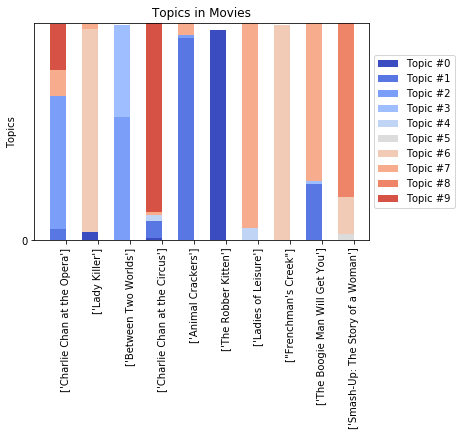

In [74]:
# First we can visualize as a stacked bar chart
# we can see here how different topics load across movie
N = 10
ind = np.arange(N)
K = movielda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Movies')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

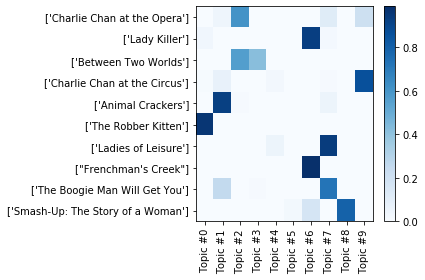

In [78]:
# We can also visualize as a heat map (shows results mirroring the bar charts)
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

In [76]:
# We can also look at the top words from each topic to get a sense of the semantic (or syntactic) domain they represent. 
movielda.show_topic(1)

[('uh', 0.011084525),
 ('captain', 0.009894643),
 ('police', 0.006839344),
 ('school', 0.0067757405),
 ('paint', 0.006610306),
 ('alright', 0.006417477),
 ('gentleman', 0.006351306),
 ('horse', 0.0062502525),
 ('avalanche', 0.0062028207),
 ('doc', 0.004888498)]

In [77]:
# if we want to make a dataFrame:
topicsDict = {}
for topicNum in range(movielda.num_topics):
    topicWords = [w for w, p in movielda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,majesty,uh,johnny,uh,doc,majesty,uh,uh,johnny,majesty
1,uh,captain,picture,mary,shoot,highness,picture,gentleman,ma,uh
2,shoot,police,lie,john,wan,child,majesty,john,gilbert,john
3,dr,school,uh,child,gun,johnny,child,captain,pa,picture
4,king,paint,madam,police,sister,goodbye,dr,paint,circus,child
5,pete,alright,eye,lie,alright,uh,wan,lie,gentleman,gentleman
6,lie,gentleman,tommy,captain,uh,steve,rock,police,child,circus
7,guard,horse,captain,gentleman,mary,papa,ship,child,bye,papa
8,order,avalanche,uncle,sister,ta,bye,gentleman,mary,eye,tommy
9,hit,doc,mary,george,car,daddy,doc,bye,car,horse
